In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wave
from scipy.io import wavfile
import contextlib
import os
import IPython


# from http://stackoverflow.com/questions/2226853/interpreting-wav-data/2227174#2227174
def interpret_wav(raw_bytes, n_frames, n_channels, sample_width, interleaved = True):

    if sample_width == 1:
        dtype = np.uint8 # unsigned char
    elif sample_width == 2:
        dtype = np.int16 # signed 2-byte short
    else:
        raise ValueError("Only supports 8 and 16 bit audio formats.")

    channels = np.frombuffer(raw_bytes, dtype=dtype)

    if interleaved:
        # channels are interleaved, i.e. sample N of channel M follows sample N of channel M-1 in raw data
        channels.shape = (n_frames, n_channels)
        channels = channels.T
    else:
        # channels are not interleaved. All samples from channel M occur before all samples from channel M-1
        channels.shape = (n_channels, n_frames)

    return channels

def get_start_end_frames(nFrames, sampleRate, tStart=None, tEnd=None):

    if tStart and tStart*sampleRate<nFrames:
        start = tStart*sampleRate
    else:
        start = 0

    if tEnd and tEnd*sampleRate<nFrames and tEnd*sampleRate>start:
        end = tEnd*sampleRate
    else:
        end = nFrames

    return (start,end,end-start)

def extract_audio(fname, tStart=None, tEnd=None):
    with contextlib.closing(wave.open(fname,'rb')) as spf:
        sampleRate = spf.getframerate()
        ampWidth = spf.getsampwidth()
        nChannels = spf.getnchannels()
        nFrames = spf.getnframes()

        startFrame, endFrame, segFrames = get_start_end_frames(nFrames, sampleRate, tStart, tEnd)

        # Extract Raw Audio from multi-channel Wav File
        spf.setpos(startFrame)
        sig = spf.readframes(segFrames)
        spf.close()

        channels = interpret_wav(sig, segFrames, nChannels, ampWidth, True)

        return (channels, nChannels, sampleRate, ampWidth, nFrames)

def convert_to_mono(channels, nChannels, outputType):
    if nChannels == 2:
        print('Fisierul audio are 2 canale')
        samples = np.mean(np.array([channels[0], channels[1]]), axis=0)  # Convert to mono
        dif = np.sum(np.abs(np.array(channels[0]) - np.array(channels[1])))
        if( dif == 0 ):
            print('\tCele doua canale sunt identice')
        else:
            print('\tExista diferente intre cele 2 canale')
    else:
        print('Fisierul audio are 1 canal')
        samples = channels[0]

    return samples.astype(outputType)

def plot_specgram(samples, sampleRate, tStart=None, tEnd=None):
    plt.figure(figsize=(20,10))
    plt.specgram(samples, Fs=sampleRate, NFFT=1024, noverlap=192, cmap='nipy_spectral', xextent=(tStart,tEnd))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

def plot_audio_samples(title, samples, sampleRate, tStart=None, tEnd=None):
    if not tStart:
        tStart = 0

    if not tEnd or tStart>tEnd:
        tEnd = len(samples)/sampleRate

    f, axarr = plt.subplots(2, sharex=True, figsize=(20,10))
    axarr[0].set_title(title)
    axarr[0].plot(np.linspace(tStart, tEnd, len(samples)), samples)
    axarr[1].specgram(samples, Fs=sampleRate, NFFT=1024, noverlap=192, cmap='nipy_spectral', xextent=(tStart,tEnd))
    #get_specgram(axarr[1], samples, sampleRate, tStart, tEnd)

    axarr[0].set_ylabel('Amplitude')
    axarr[1].set_ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')

    plt.show()
    
def plot_two_channels(title, channel1, channel2, sampleRate, tStart=None, tEnd=None):
    if not tStart:
        tStart = 0

    if not tEnd or tStart>tEnd:
        tEnd = len(samples)/sampleRate
        
    plt.figure(figsize=(14, 5), dpi=80)
    plt.title(title)
    plt.plot(np.linspace(tStart, tEnd, len(channel1)), channel1, 'b')
    plt.plot(np.linspace(tStart, tEnd, len(channel2)), channel2, 'r')

    plt.ylabel('Amplitude')
    plt.xlabel('Time [sec]')

    plt.show()\
    
def get_audio_duration( file_name ):
    with contextlib.closing(wave.open(file_name,'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
        return (duration, rate)
    return (0, 0)

In [2]:
# Folosind fișierul audio song.wav, tăiați intervalul [1, 1:30]min și salvați într-un fișier numit song_cut.wav.

audio_file = 'song.wav'
channels, nChannels, sampleRate, ampWidth, nFrames = extract_audio(audio_file, 60, 90)
wavfile.write('song_cut.wav', sampleRate, channels.T)

In [3]:
# Folosind song_cut.wav, salvați cele 2 canale în fișiere separate, song_channel1.wav și song_channel2.wav.
audio_file = 'song_cut.wav'
duration = get_audio_duration( audio_file )[0]

channels, nChannels, sampleRate, ampWidth, nFrames = extract_audio(audio_file, 0, duration)

channel1 = channels[0].astype(np.int16)
channel2 = channels[1].astype(np.int16)

# Scriere fisere separate pentru fiecare canal
wavfile.write('song_channel1.wav', sampleRate, channel1.T)
wavfile.write('song_channel2.wav', sampleRate, channel2.T)

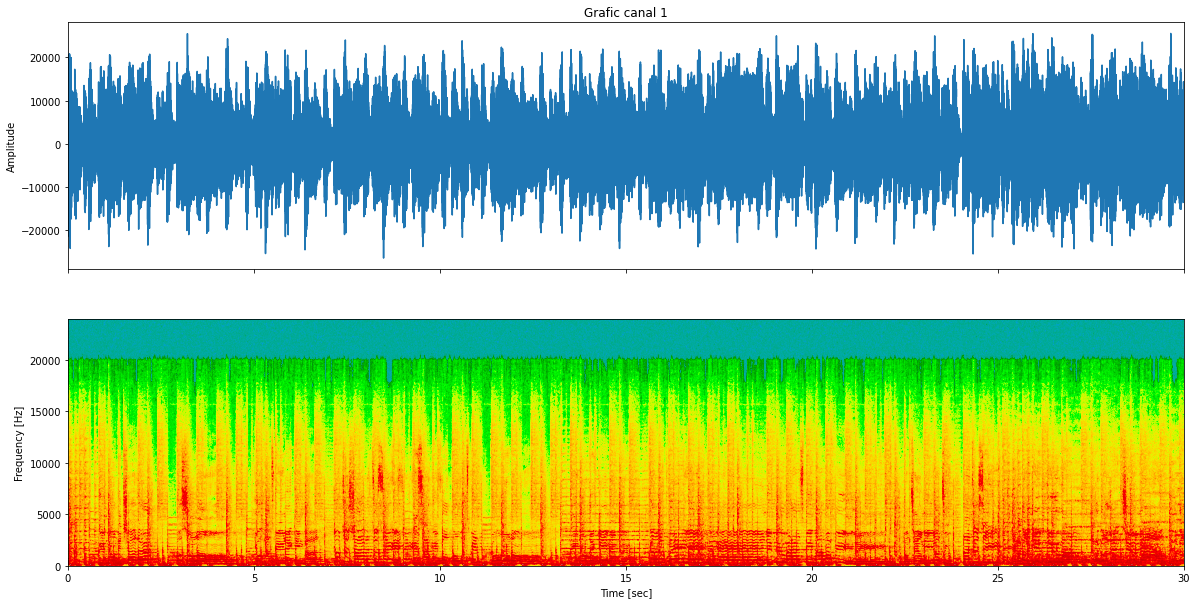

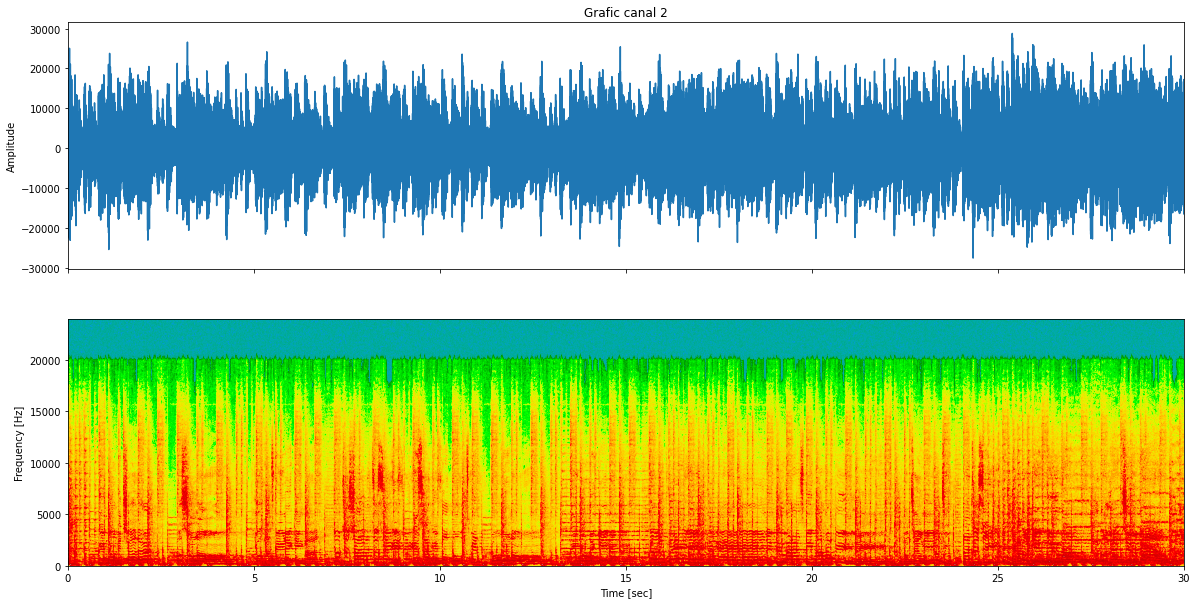

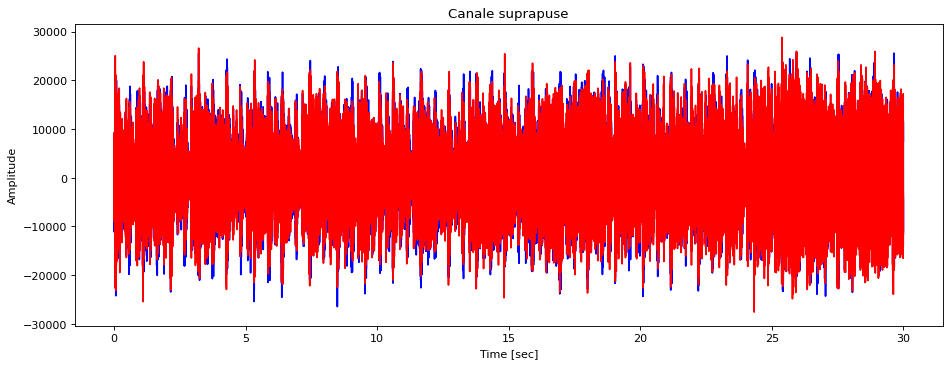

In [4]:
# Afișați graficele de amplitudine și frecvență ale celor două canale (separat) și graficul de amplitudine ale canalelor suprapuse

plot_audio_samples("Grafic canal 1", channel1, sampleRate, 0, duration)
plot_audio_samples("Grafic canal 2", channel2, sampleRate, 0, duration)

# Plotare canale suprapuse
plot_two_channels("Canale suprapuse", channel1, channel2, sampleRate, 0, duration)

In [5]:
# Folosind metadatele fișierului, afișați bit depth-ul, bitrate-ul și sample rate-ul pentru song.wav
import audio_metadata

metadata = audio_metadata.load( 'song_cut.wav' )
print("bit depth: ", metadata.streaminfo.bit_depth, "\nbitrate: ",  metadata.streaminfo.bitrate, "\nsample rate: ", metadata.streaminfo.sample_rate)

bit depth:  16 
bitrate:  1536000 
sample rate:  48000


In [6]:
# Folosind fișierul audio song_cut.wav, aplicați un filtru trece bandă în intervalul de frecvențe [2000, 10000]Hz, 
# un filtru trece jos cu frecvența de tăiere de 3kHz și un filtru trece sus cu frecvența de tăiere de 5kHz. 
# Pentru fiecare filtrare salvați un fișier separat cu numele filtrului (trece_jos.wav, trece_sus.wav, trece_banda.wav) 
# și afișați graficele de amplitudine și frecvență.


In [7]:
# definire filtre

def fir_high_pass(samples, fs, fH, N, outputType):
    # Referece: https://fiiir.com

    fH = fH / fs

    # Compute sinc filter.
    h = np.sinc(2 * fH * (np.arange(N) - (N - 1) / 2.))
    # Apply window.
    h *= np.hamming(N)
    # Normalize to get unity gain.
    h /= np.sum(h)
    # Create a high-pass filter from the low-pass filter through spectral inversion.
    h = -h
    h[int((N - 1) / 2)] += 1
    # Applying the filter to a signal s can be as simple as writing
    s = np.convolve(samples, h).astype(outputType)
    return s


def fir_low_pass(samples, fs, fL, N, outputType):
    # Referece: https://fiiir.com

    fL = fL / fs

    # Compute sinc filter.
    h = np.sinc(2 * fL * (np.arange(N) - (N - 1) / 2.))
    # Apply window.
    h *= np.hamming(N)
    # Normalize to get unity gain.
    h /= np.sum(h)
    # Applying the filter to a signal s can be as simple as writing
    s = np.convolve(samples, h).astype(outputType)
    return s

def fir_band_reject(samples, fs, fL, fH, NL, NH, outputType):
    # Referece: https://fiiir.com

    fH = fH / fs
    fL = fL / fs

    # Compute a low-pass filter with cutoff frequency fL.
    hlpf = np.sinc(2 * fL * (np.arange(NL) - (NL - 1) / 2.))
    hlpf *= np.blackman(NL)
    hlpf /= np.sum(hlpf)
    # Compute a high-pass filter with cutoff frequency fH.
    hhpf = np.sinc(2 * fH * (np.arange(NH) - (NH - 1) / 2.))
    hhpf *= np.blackman(NH)
    hhpf /= np.sum(hhpf)
    hhpf = -hhpf
    hhpf[int((NH - 1) / 2)] += 1
    # Add both filters.
    if NH >= NL:
        h = hhpf
        h[int((NH - NL) / 2) : int((NH - NL) / 2 + NL)] += hlpf
    else:
        h = hlpf
        h[int((NL - NH) / 2) : int((NL - NH) / 2 + NH)] += hhpf
    # Applying the filter to a signal s can be as simple as writing
    s = np.convolve(samples, h).astype(outputType)

    return s

def fir_band_pass(samples, fs, fL, fH, NL, NH, outputType):
    # Referece: https://fiiir.com

    fH = fH / fs
    fL = fL / fs

    # Compute a low-pass filter with cutoff frequency fH.
    hlpf = np.sinc(2 * fH * (np.arange(NH) - (NH - 1) / 2.))
    hlpf *= np.blackman(NH)
    hlpf /= np.sum(hlpf)
    # Compute a high-pass filter with cutoff frequency fL.
    hhpf = np.sinc(2 * fL * (np.arange(NL) - (NL - 1) / 2.))
    hhpf *= np.blackman(NL)
    hhpf /= np.sum(hhpf)
    hhpf = -hhpf
    hhpf[int((NL - 1) / 2)] += 1
    # Convolve both filters.
    h = np.convolve(hlpf, hhpf)
    # Applying the filter to a signal s can be as simple as writing
    s = np.convolve(samples, h).astype(outputType)

    return s

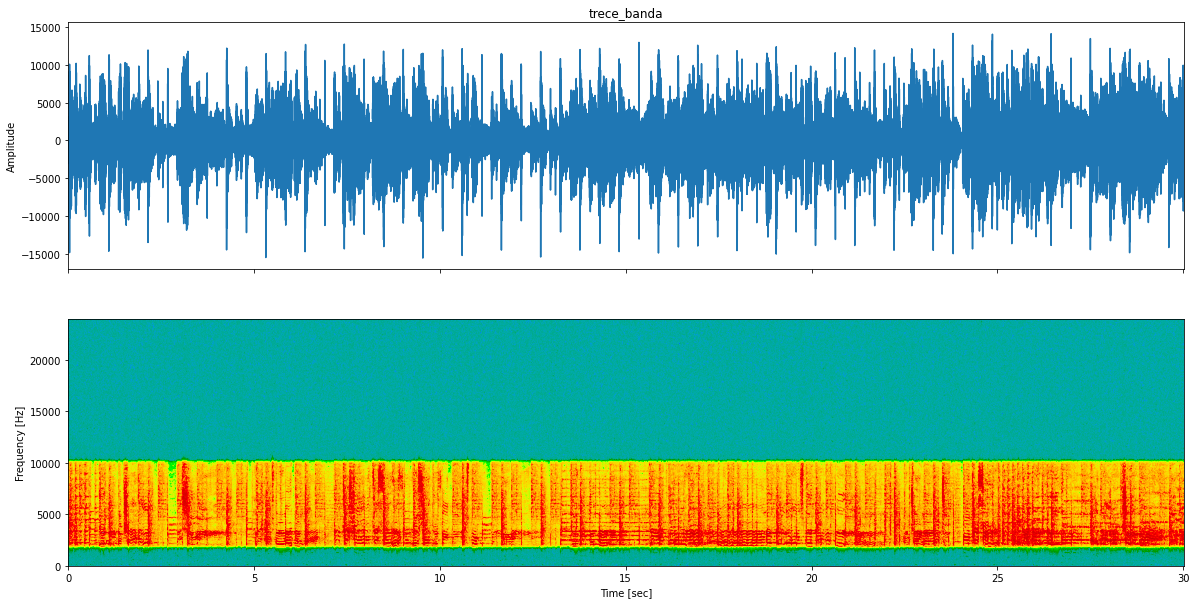

In [8]:
# filtru trece bandă în intervalul de frecvențe [2000, 10000]Hz

channels, nChannels, sampleRate, ampWidth, nFrames = extract_audio('song_cut.wav', 0, duration)
channel1 = channels[0].astype(np.int16)
channel2 = channels[1].astype(np.int16)

samples_filtered1 = fir_band_pass(channel1 , sampleRate, 2000, 10000, 461, 461, np.int16)
samples_filtered2 = fir_band_pass(channel2, sampleRate, 2000, 10000, 461, 461, np.int16)

trece_banda = np.array([samples_filtered1.tolist(), samples_filtered2.tolist()]).astype(np.int16) # stereo

wavfile.write('trece_banda.wav', sampleRate, trece_banda.T)

plot_audio_samples("trece_banda", samples_filtered1, sampleRate)


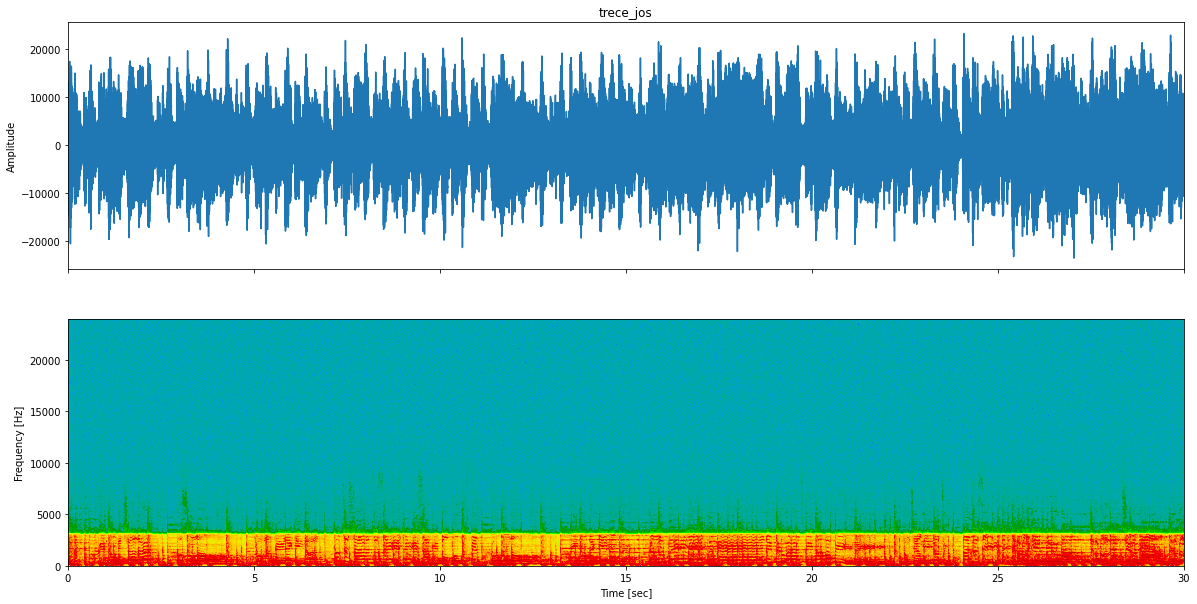

In [9]:
#filtru trece jos cu frecvența de tăiere de 3kHz


channels, nChannels, sampleRate, ampWidth, nFrames = extract_audio('song_cut.wav', 0, duration)
channel1 = channels[0].astype(np.int16)
channel2 = channels[1].astype(np.int16)

samples_filtered1 = fir_low_pass(channel1 , sampleRate, 3000, 461, np.int16)
samples_filtered2 = fir_low_pass(channel2 , sampleRate, 3000, 461, np.int16)

trece_jos = np.array([samples_filtered1.tolist(), samples_filtered2.tolist()]).astype(np.int16) # stereo

wavfile.write('trece_jos.wav', sampleRate, trece_jos.T)

plot_audio_samples("trece_jos", samples_filtered1, sampleRate)

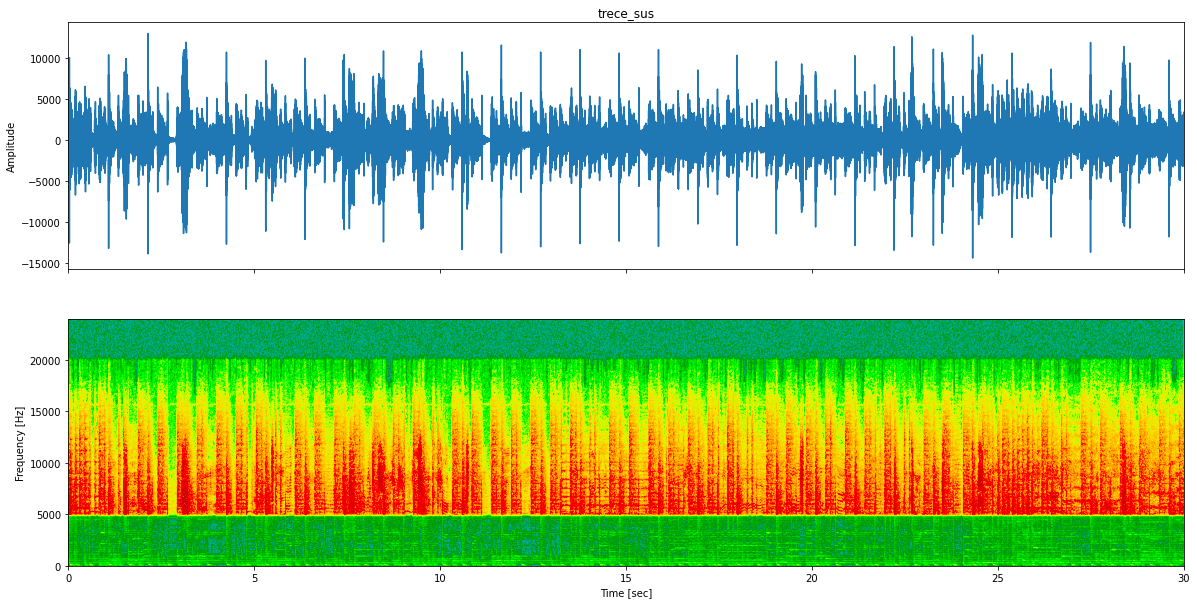

In [10]:
#filtru trece sus cu frecvența de tăiere de 5kHz

channels, nChannels, sampleRate, ampWidth, nFrames = extract_audio('song_cut.wav', 0, duration)
channel1 = channels[0].astype(np.int16)
channel2 = channels[1].astype(np.int16)

samples_filtered1 = fir_high_pass(channel1 , sampleRate, 5000, 461, np.int16)
samples_filtered2 = fir_high_pass(channel2 , sampleRate, 5000, 461, np.int16)

trece_sus = np.array([samples_filtered1.tolist(), samples_filtered2.tolist()]).astype(np.int16) # stereo

wavfile.write('trece_sus.wav', sampleRate, trece_sus.T)

plot_audio_samples("trece_sus", samples_filtered1, sampleRate)

In [11]:
# Folosind fișierul image.png, micșorați dimensiunile imaginii cu un factor de 1.1. 
# Afișați rezultatul pe ecran și salvați într-un fișier cu denumirea image_redim.png.

import cv2
import numpy as np

img = cv2.imread('image.png')

img_shape = img.shape
height = img_shape[0]
width = img_shape[1]
img_redimensionata = cv2.resize(img, (int(width / 1.1), int(height / 1.1)))

cv2.imwrite('image_redim.png', img_redimensionata)

cv2.imshow('img_redim', img_redimensionata)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [12]:
# Convertiți imaginea redimensionată în grayscale. Afișați rezultatul pe ecran și salvați într-un fișier image_gray.png.
img = cv2.imread('image_redim.png')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

cv2.imwrite('image_gray.png', gray)

cv2.imshow('img_gray', gray)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [13]:
# Salvați imaginea redimensionată ca un JPEG cu rata de compresie 20, image.jpg.
img = cv2.imread('image_redim.png')
cv2.imwrite('image.jpg', img, [int(cv2.IMWRITE_JPEG_QUALITY), 20])

True

In [14]:
# Salvați fiecare canal ca o imagine color, de culoarea canalului (canalul roșu cu roșu, etc.), 
# cu denumirile image_red.png, image_blue.png, image_green.png.
img = cv2.imread('image.jpg')

red_computed = np.array(img[:,:,2]).astype(np.uint8)
green_computed = np.array(img[:,:,1]).astype(np.uint8)
blue_computed = np.array(img[:,:,0]).astype(np.uint8)

red_frame = np.zeros_like(img)
red_frame[:,:,2] = red_computed

green_frame = np.zeros_like(img)
green_frame[:,:,1] = green_computed

blue_frame = np.zeros_like(img)
blue_frame[:,:,0] = blue_computed


cv2.imwrite('image_red.png', red_frame)
cv2.imwrite('image_blue.png', blue_frame)
cv2.imwrite('image_green.png', green_frame)

True

In [15]:
# Tăiați imaginea redimensionată de la rândul 275 la rândul 875, și de la coloana 250 la coloana 850. 
# Afișați rezultatul pe ecran și salvați într-un fișier cu denumirea image_cut.png.

img = cv2.imread('image_redim.png')

img = img[275:875, 250:850]

cv2.imwrite('image_cut.png', img)

cv2.imshow('img_cut', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [16]:
# Pe imaginea inițială redimensionată, aplicați canalul de transparență al imaginii tree.png. 
# Afișați rezultatul pe ecran (astfel încât masca să fie vizibilă pe ecran) și salvați într-un fișier image_mask.png.

def jpeg_to_png_with_transparency(image, alpha_channel):
    # Redimensionam imaginea daca este necesar
    if( (image.shape[0] != alpha_channel.shape[0]) or (image.shape[1] != alpha_channel.shape[1]) ):
        image = cv2.resize(image, (alpha_channel.shape[1], alpha_channel.shape[0]))
                           
    # Creare imagine goala (neagra) de aceeasi dimensiune cu imaginea initiala, dar cu canal de alfa
    output = np.zeros((image.shape[0], image.shape[1], 4))
    
    output[:,:,0:3] = image.copy()
    output[:,:,3] = alpha_channel
    output = output.astype(np.uint8)
    
    # Extragere indecsi unde canalul alfa este 0 (unde imaginea trebuie sa fie transparenta)
    # alpha_zero este un tuplu care va contine 2 array-uri: 
    # primul array va specifica randul (x), iar al doilea array va specifica coloana (y)
    # pe care exista un pixel care trebuie sa fie transparent
    alpha_zero = np.where(alpha_channel == 0)
    
    for i in range(0, len(alpha_zero[0])):
        output[alpha_zero[0][i], alpha_zero[1][i], 0:3] = [0, 0, 0]
        
    return output

png_image = cv2.imread("tree.png", cv2.IMREAD_UNCHANGED)  #Read with alpha channel included
jpg_image = cv2.imread("image_redim.png")
output = jpeg_to_png_with_transparency(jpg_image, png_image[:,:,3])


cv2.imwrite("image_mask.png", output)
cv2.imshow("image_mask", output)
cv2.waitKey(0)
cv2.destroyAllWindows()